# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

In [ ]:
%matplotlib inline


# Classifying Names with a Character-Level RNN

We will biuld and train a character-level *Recurrent Neural
Network* (*RNN*) to classify words.

A character-level RNN reads words as a series of characters -
it outputs a prediction and hidden state at each step, and feeds the
previous hidden state into each next step. We take the final prediction
to be the output, that represents which class the word belongs to.

We want to predict the Language class to which belongs the Surnames.

## Preparing the Data

We will create a dictionary of lists of names per language,
``{language: [names ...]}``.


In [1]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 39), reused 81 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 1.55 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
# general import

import os
from glob import glob
from io import open
import string
import numpy as np
import random

import torch
import torch.nn as nn


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running application on {device}')

Running application on cpu


In [3]:
def getFiles(path):
  return glob(path)

file_list = getFiles('./data/Names/*.txt')
print(file_list[:2])

['./data/Names/Chinese.txt', './data/Names/Arabic.txt']


In [4]:
!rm -r pytorch-tutorial-nlp-public/

In [5]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

print(readLines(file_list[0]))
print(readLines(file_list[1]))

['Ang', 'Au-Yong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao', 'Cen', 'Chai', 'Chaim', 'Chan', 'Chang', 'Chao', 'Che', 'Chen', 'Cheng', 'Cheung', 'Chew', 'Chieu', 'Chin', 'Chong', 'Chou', 'Chu', 'Cui', 'Dai', 'Deng', 'Ding', 'Dong', 'Dou', 'Duan', 'Eng', 'Fan', 'Fei', 'Feng', 'Foong', 'Fung', 'Gan', 'Gauk', 'Geng', 'Gim', 'Gok', 'Gong', 'Guan', 'Guang', 'Guo', 'Gwock', 'Han', 'Hang', 'Hao', 'Hew', 'Hiu', 'Hong', 'Hor', 'Hsiao', 'Hua', 'Huan', 'Huang', 'Hui', 'Huie', 'Huo', 'Jia', 'Jiang', 'Jin', 'Jing', 'Joe', 'Kang', 'Kau', 'Khoo', 'Khu', 'Kong', 'Koo', 'Kwan', 'Kwei', 'Kwong', 'Lai', 'Lam', 'Lang', 'Lau', 'Law', 'Lew', 'Lian', 'Liao', 'Lim', 'Lin', 'Ling', 'Liu', 'Loh', 'Long', 'Loong', 'Luo', 'Mah', 'Mai', 'Mak', 'Mao', 'Mar', 'Mei', 'Meng', 'Miao', 'Min', 'Ming', 'Moy', 'Mui', 'Nie', 'Niu', 'Ou-Yang', 'Ow-Yang', 'Pan', 'Pang', 'Pei', 'Peng', 'Ping', 'Qian', 'Qin', 'Qiu', 'Quan', 'Que', 'Ran', 'Rao', 'Rong', 'Ruan', 'Sam', 'Seah', 'See ', 'Seow', 'Seto', 'Sha', 'Shan', 

In [6]:
# category_words is a dict with the key as the language
# and the value a list with all the possible names in the specific language
category_words = {}
all_categories = []
alphabet = set()

for filename in file_list:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for word in lines:
      alphabet |= set(word)
    category_words[category] = lines

# letter to index
l_to_i = dict(zip(alphabet, range(len(alphabet))))
print(category_words)
n_categories = len(all_categories)
print(f'N. of languages: {n_categories}')
print(l_to_i)
n_letters = len(l_to_i)
print(f'The alphabet has {n_letters} letters')

{'Chinese': ['Ang', 'Au-Yong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao', 'Cen', 'Chai', 'Chaim', 'Chan', 'Chang', 'Chao', 'Che', 'Chen', 'Cheng', 'Cheung', 'Chew', 'Chieu', 'Chin', 'Chong', 'Chou', 'Chu', 'Cui', 'Dai', 'Deng', 'Ding', 'Dong', 'Dou', 'Duan', 'Eng', 'Fan', 'Fei', 'Feng', 'Foong', 'Fung', 'Gan', 'Gauk', 'Geng', 'Gim', 'Gok', 'Gong', 'Guan', 'Guang', 'Guo', 'Gwock', 'Han', 'Hang', 'Hao', 'Hew', 'Hiu', 'Hong', 'Hor', 'Hsiao', 'Hua', 'Huan', 'Huang', 'Hui', 'Huie', 'Huo', 'Jia', 'Jiang', 'Jin', 'Jing', 'Joe', 'Kang', 'Kau', 'Khoo', 'Khu', 'Kong', 'Koo', 'Kwan', 'Kwei', 'Kwong', 'Lai', 'Lam', 'Lang', 'Lau', 'Law', 'Lew', 'Lian', 'Liao', 'Lim', 'Lin', 'Ling', 'Liu', 'Loh', 'Long', 'Loong', 'Luo', 'Mah', 'Mai', 'Mak', 'Mao', 'Mar', 'Mei', 'Meng', 'Miao', 'Min', 'Ming', 'Moy', 'Mui', 'Nie', 'Niu', 'Ou-Yang', 'Ow-Yang', 'Pan', 'Pang', 'Pei', 'Peng', 'Ping', 'Qian', 'Qin', 'Qiu', 'Quan', 'Que', 'Ran', 'Rao', 'Rong', 'Ruan', 'Sam', 'Seah', 'See ', 'Seow', 'Seto', 'Sh

In [7]:
# this is all the necessary code to set the seed
def set_seed(seed : int = 123):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [8]:
set_seed()

### Turning Names into Tensors

As always, we have to convert textual data into tensors.

To represent a single letter, we use a "one-hot vector" of size
``(1 x n_letters)``, where 1 is the respective index of the letter it is representing.

To make a word we combine a bunch of those representations into a 2D matrix
``(word_length x 1 x n_letters)``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here, for the sake of simplicity.




# Question 1
Create the auxiliary function to process the data to have the input suitable for `nn.Embedding`. This is because one of the following questions will be to try not to use one-hot-encoding representation, but use the embedding layer instead.

In [9]:
def letterToIndex(letter):
  '''
  Returns the index of a letter in the alphabet
  '''
  return l_to_i[letter]

def wordToOneHotTensor(word):
  '''
  Returns the word in zero-hot encoding
  '''
  tensor = torch.zeros(len(word), 1, n_letters).long()
  for idx, let in enumerate(word):
      tensor[idx][0][letterToIndex(let)] = 1
  return tensor

def wordToEmbedding(word):
  indexes = [letterToIndex(letter) for letter in word]
  return torch.tensor(indexes, dtype=torch.long)

tmp = 'Aarle'

print(f'N. of letters {len(alphabet)}')
print(f'Length of the word {len(tmp)}\n')
print(wordToOneHotTensor(tmp).size())
print(wordToOneHotTensor(tmp))
print('\n')
print(wordToEmbedding(tmp).size())
print(wordToEmbedding(tmp))

N. of letters 87
Length of the word 5

torch.Size([5, 1, 87])
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0

# Question 2
Implement the Vanilla RNN considering a batch size of dimension 1 (the simplest case).

## Creating the Network

Here, we are going to create RNNs with one only layer for the sake of simplicity. However, these models can be easily expanded to the more general case of having more layers.  

The Vanilla RNN is just 2 linear layers which operate on an input and hidden state.




In [10]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size).to(device)

In [11]:
class RNNEmb(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNNEmb, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.embedding = nn.Embedding(input_size, hidden_size)

    self.e2h = nn.Linear(hidden_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    embedded = self.embedding(input)
    combined = torch.cat((torch.unsqueeze(embedded, 0), hidden), 1)
    hidden = self.e2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size).to(device)

# Question 3
Implement an LSTM cell considering a batch size of dimension 1 (the simplest case).

In [12]:
class LSTM(torch.nn.Module):

    def __init__(self, input_length, hidden_length, output_length, type_layer):
        super(LSTM, self).__init__()

        self.input_length = input_length
        self.hidden_length = hidden_length
        self.output_length = output_length
        self.type_layer = type_layer

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_input_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.linear_input_w2 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_input = nn.Sigmoid()
        self.tanh_input = nn.Tanh()

        # out gate components
        self.linear_output_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_out = nn.Sigmoid()

        # final compnents
        self.linear_output_final = nn.Linear(self.hidden_length, self.output_length, bias=True)
        self.activation_final = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forget(self, x, h):
        # forget gate
        ret = self.linear_forget_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_forget(ret)


    def input_gate(self, x, h):
        # input gate
        i_t = self.linear_input_w1(torch.cat((x, h), dim=1))
        C_t = self.linear_input_w2(torch.cat((x, h), dim=1))
        return self.sigmoid_input(i_t), self.tanh_input(C_t)


    def out_gate(self, x, h):
        ret = self.linear_output_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_out(ret)


    def forward(self, x, tuple_in):
        x = x.to(torch.float32)
        (h, c_prev) = tuple_in

        # forget gate
        f_t = self.forget(x, h)

        # input gate
        i_t, c_t = self.input_gate(x, h)

        # updating the cell memory
        c_next = (c_prev * f_t) + (i_t * c_t)

        # calculate the main output gate
        o = self.out_gate(x, h)

        # produce next hidden output
        h_next = o * self.activation_final(c_next)

        return self.log_softmax(self.linear_output_final(h_next)), (h_next, c_next)


    def initHidden(self):
        return (torch.zeros(1, self.hidden_length).to(torch.float32).to(device), torch.zeros(1, self.hidden_length).to(torch.float32).to(device))

## Training
Preparing for Training
----------------------

The output of the network is a likelihood of each category. Use ``Tensor.topk`` to get the index
of the greatest value:




In [13]:
def categoryFromOutput(output):
    top_val, top_idx = output.topk(1)
    category_idx = top_idx[0].item()
    return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its
language):




In [14]:
print(all_categories)

['Chinese', 'Arabic', 'English', 'Portuguese', 'Italian', 'Czech', 'Vietnamese', 'Japanese', 'Spanish', 'Korean', 'German', 'Russian', 'Irish', 'Scottish', 'Dutch', 'Polish', 'French', 'Greek']


# Related to Question 1
In order to use the embeddings in place of one-hot-encoded representation, you should modify also the function `randomChoice()` in the following snippet of code to have the correct input data.

In [15]:
import random

def randomChoice(l):
  '''
  Returns a random integer given the list of languages
  '''
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(model):
    category = randomChoice(all_categories)
    word = randomChoice(category_words[category])
    # create a long tensor with the index of the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    if model == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)

    return category, word, category_tensor, word_tensor

for ty in ['embeds', 'linear']:
  for i in range(4):
    category, word, category_tensor, word_tensor = randomTrainingExample(ty)
    print('category =', category, '\n word =', word, '\n category_tensor =', category_tensor, '\n word_tensor =', word_tensor, '\n len word_tensor =', word_tensor.size())
    print('\n')

category = Arabic 
 word = Zogby 
 category_tensor = tensor([1]) 
 word_tensor = tensor([26, 14,  6, 59, 13]) 
 len word_tensor = torch.Size([5])


category = English 
 word = Sweeney 
 category_tensor = tensor([2]) 
 word_tensor = tensor([74,  9, 40, 40, 65, 40, 13]) 
 len word_tensor = torch.Size([7])


category = Scottish 
 word = Cameron 
 category_tensor = tensor([13]) 
 word_tensor = tensor([18,  0, 75, 40, 19, 14, 65]) 
 len word_tensor = torch.Size([7])


category = Portuguese 
 word = Araújo 
 category_tensor = tensor([3]) 
 word_tensor = tensor([56, 19,  0,  4, 23, 14]) 
 len word_tensor = torch.Size([6])


category = Irish 
 word = O'Brien 
 category_tensor = tensor([12]) 
 word_tensor = tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Training the Network
 In the following change the initialisation with the model you want to use.




In [16]:
n_hidden = 128
criterion = nn.NLLLoss()

In [17]:
rnn = RNN(n_letters, n_hidden, n_categories, 'linear').to(device)
next(rnn.parameters()).device

device(type='cpu')

In [18]:
rnn_embeds = RNNEmb(n_letters, n_hidden, n_categories, 'embeds').to(device)
next(rnn_embeds.parameters()).device

device(type='cpu')

In [19]:
lstm = LSTM(n_letters, n_hidden, n_categories, 'linear').to(device)
next(lstm.parameters()).device

device(type='cpu')

Each loop of training will:

1. Create input and target tensors
2. Read each letter in and keep the hidden state for next letter
3. Compare final output to target
4. Back-propagate
5. Return the output and loss




# Question 3.1
After having tryied the learning rate which is proposed in the script, `0.005`, use the learning rate equal to `1`. What is happening? Can you explaing why?

## Answer
It is happening that the loss goes to NAN values, indeed the problem that we are experiencing in this case is the so-called **exploding gradient problem**. The Point is that the RNN backbone has the drawback that the closer I move to the end of the sequence of inputs the more I have to add and to multiply the weights of my network. So during the training the gradient might *vanishing* or *exploding* like in this case, so it means that I will not learn long term dependencies.

\begin{equation}
A_t = \Theta_cA_{t-1} + \Theta_xx_t
\end{equation}

Let's consider the recurrence on the hidden space and forget the input
\begin{equation}
 A_t = \Theta_cA_{t-1}
\end{equation}

\begin{equation}
\begin{aligned}
A_1 &= \Theta_cA_0\\
A_2 &= \Theta_cA_1 = \Theta_c(\Theta_cA_0) = \Theta_c^2A_0\\
A_3 &= \Theta_cA_2 = \Theta_c(\Theta_cA_1) = \Theta_c(\Theta_c(\Theta_cA_0)) = \Theta_c^3A_0\\
...\\
A_t &= \Theta_c^tA_0 \quad \text{the parameters are muiltiplied t times}
\end{aligned}
\end{equation}




# Question 3.2
What is the quickest way to get rid of the problem? Modify the code trying to implement a possible solution.
## Answer
The quickest way to get rid of the problem is to modify the code inserting the **gradient clipping**.

Let's $g = \frac{\partial\mathcal{L}}{\partial \Theta_c}$ are the gradeitns of the loss $\mathcal{L}$ with respect to the model's parameters $\Theta_c$

If $||g|| \leq c$ then $g = c \cdot \frac{g}{||g||}$, this ensure that I have no longer strong weights since I make the norm of $g$ maximum of $c$ . Indeed this helps the gradient descent to have a resonabe behaviour even if the loss landscape of the model is irregular.

# Question 3.2
What is the other problem this kind of network has? And what are the possible solutions?
## Answer
The architecture has multiple drawbacks but the main two are the following one:
1. **Limited Contextual Information**: RNNs have a limited ability to capture long-range dependencies in sequences. This is because they suffer from the vanishing gradient problem, which hampers their ability to retain information over many time steps.
2. **Difficulty Learning Long-Term Dependencies**: RNNs find it challenging to learn dependencies that are separated by a large number of time steps. This limits their ability to capture long-term dependencies in sequences. For example, given a sequence of words the information of the first word that is kept at the last input is very insignificant with respect to the last input word.

One of the possible solutions is to switch to an LSTM architecture. The LSTM has the following main advantages with respect to a classical RNN:
1. **Gating Structure**: LSTMs incorporate a gating mechanism that consists of input, forget, and output gates. These gates control the information flow, allowing the network to decide what information to keep or forget at each time step.
2. **Long-Term Dependency Handling**: LSTMs are designed to address the vanishing gradient problem, allowing them to capture long-term dependencies. This is achieved through the use of a gating mechanism that regulates the flow of information through the cell state which as the main goal to retain the long term memory.
3. **Reduced Vanishing Gradient**: The architecture of LSTMs reduces the vanishing gradient problem, making it possible to capture long term dependencies through the all input sequence.

In [20]:
from torch import optim


def train(category_tensor, word_tensor, model, optimizer):

    h = model.initHidden()

    optimizer.zero_grad()
    # iterate over the word for all the letters in the word
    for i in range(word_tensor.size(0)):

        output, h = model(word_tensor[i], h)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Basic Gradient Clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 1.)

    optimizer.step()
    return output, loss.item()

The ``train`` function returns the output and loss we can print what are its predictions and also to keep track of the loss.
We can choose how many examples print these outputs thanks to ``print_every``.




In [21]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

def run_training(model, optimizer):
  n_iters = 100000
  print_every = 5000
  plot_every = 1000

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []

  model.train()

  start = time.time()

  for iter in range(1, n_iters + 1):
      category, word, category_tensor, word_tensor = randomTrainingExample(model.type_layer)

      category_tensor = category_tensor.to(device)
      word_tensor = word_tensor.to(device)

      output, loss = train(category_tensor, word_tensor, model, optimizer)
      current_loss += loss

      if iter % print_every == 0:
          category_pred, category_idx = categoryFromOutput(output)
          correct = 'OK' if category_pred == category else 'NO (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, word, category_pred, correct))

      # add the current loss to the list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

  return all_losses

In [22]:
optimizer_rnn = optim.SGD(rnn.parameters(), lr = 0.005)

rnn_losses = run_training(rnn, optimizer_rnn)

5000 5% (0m 10s) 2.6868 Dziadik / Polish NO (Czech)
10000 10% (0m 19s) 4.7262 Boutros / Greek NO (Arabic)
15000 15% (0m 30s) 1.3565 Ceallachan / Scottish NO (Irish)
20000 20% (0m 41s) 2.9866 Navara / Arabic NO (Czech)
25000 25% (0m 52s) 0.2821 Peusen / Dutch OK
30000 30% (1m 2s) 0.4129 Zhitukhin / Russian OK
35000 35% (1m 12s) 1.5716 Matsuoka / Czech NO (Japanese)
40000 40% (1m 22s) 0.0320 Konstantatos / Greek OK
45000 45% (1m 31s) 3.4341 Satorie / French NO (Czech)
50000 50% (1m 42s) 0.9680 Koziol / Polish OK
55000 55% (1m 52s) 1.9382 Stewart / German NO (Scottish)
60000 60% (2m 1s) 0.5401 Glynatsis / Greek OK
65000 65% (2m 11s) 3.6550 Roldán / Dutch NO (Spanish)
70000 70% (2m 21s) 0.0518 Bouloukos / Greek OK
75000 75% (2m 31s) 2.9320 Cham / Korean NO (Arabic)
80000 80% (2m 42s) 0.3114 Song / Chinese OK
85000 85% (2m 53s) 0.0122 Oh  / Korean OK
90000 90% (3m 2s) 1.3867 Easdown / Irish NO (English)
95000 95% (3m 12s) 1.5119 Terrazas / Portuguese NO (Spanish)
100000 100% (3m 22s) 0.2284

In [23]:
optimizer_rnn_embeds = optim.SGD(rnn_embeds.parameters(), lr = 0.005)

rnn_embeds_losses = run_training(rnn_embeds, optimizer_rnn_embeds)

5000 5% (0m 15s) 0.4287 Yi / Korean OK
10000 10% (0m 27s) 0.2231 Matsoukis / Greek OK
15000 15% (0m 40s) 2.8461 Luttrell / Scottish NO (English)
20000 20% (0m 51s) 1.6739 Najjar / Polish NO (Arabic)
25000 25% (1m 3s) 0.0123 Shalunov / Russian OK
30000 30% (1m 15s) 0.4236 Márquez / Spanish OK
35000 35% (1m 27s) 0.1782 Quan / Chinese OK
40000 40% (1m 40s) 0.0331 Uccello / Italian OK
45000 45% (1m 53s) 0.6525 Niall / Irish OK
50000 50% (2m 4s) 0.1724 Sin / Korean OK
55000 55% (2m 16s) 0.0227 Rudawski / Polish OK
60000 60% (2m 28s) 1.4209 Makiguchi / Italian NO (Japanese)
65000 65% (2m 41s) 1.3132 Faolan / Irish OK
70000 70% (2m 54s) 5.5299 De laurentis / Greek NO (Italian)
75000 75% (3m 6s) 0.1773 Yue / Chinese OK
80000 80% (3m 18s) 3.3836 Villalobos / Greek NO (Spanish)
85000 85% (3m 29s) 2.3587 Tso / Vietnamese NO (Chinese)
90000 90% (3m 41s) 0.8569 Kahae / Japanese OK
95000 95% (3m 53s) 0.6826 Almeida / Portuguese OK
100000 100% (4m 5s) 0.0913 Hiu / Chinese OK


In [24]:
optimizer_lstm = optim.Adam(lstm.parameters(), lr = 0.001)

lstm_losses = run_training(lstm, optimizer_lstm)

5000 5% (0m 40s) 1.9493 Mcdonald / Irish NO (Scottish)
10000 10% (1m 24s) 0.1179 Kanavos / Greek OK
15000 15% (2m 7s) 0.0069 Kurosawa / Japanese OK
20000 20% (2m 50s) 0.6291 Wood / Scottish OK
25000 25% (3m 31s) 0.2067 Tong / Vietnamese OK
30000 30% (4m 12s) 2.0947 Macarthur / French NO (English)
35000 35% (4m 54s) 1.6323 Koo / Korean NO (Chinese)
40000 40% (5m 36s) 0.7195 Sachs / German OK
45000 45% (6m 18s) 0.2173 Costa / Portuguese OK
50000 50% (7m 0s) 1.6828 Leitzke / Czech NO (German)
55000 55% (7m 42s) 0.0000 Pantelakos / Greek OK
60000 60% (8m 24s) 0.5376 Gosden / English OK
65000 65% (9m 5s) 0.0020 Ghanem / Arabic OK
70000 70% (9m 47s) 0.0269 Quang / Vietnamese OK
75000 75% (10m 29s) 0.0010 Ryoo / Korean OK
80000 80% (11m 11s) 0.0300 Dam / Vietnamese OK
85000 85% (11m 52s) 0.0054 Kassis / Arabic OK
90000 90% (12m 33s) 0.0044 Atanasyan / Russian OK
95000 95% (13m 15s) 0.0053 Adami / Italian OK
100000 100% (13m 57s) 0.1472 Torres / Portuguese OK


# Question 4
Use the LSTM to make the predictions, feel free to modify the optimizer and/or the learning rate to see the training loss decreasing. Pay attention that the LSTM returns a number of components different by the ones that are returned by a Vanilla RNN, thus modify the code accordingly (especially the `train()` function).


# Question 5
Modify the network of the Vanilla RNN to use an embedding layer and not using the one-hot-encoding representation and train again the network. Verify that the network has been trained considering the training loss. It has to be decreasing.

### See that the training loss is decreasing

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def print_losses(all_losses, title):
  plt.figure()
  plt.plot(all_losses)
  plt.xlabel('Iterations')
  plt.ylabel('NLLLoss')
  plt.title(title)
  plt.show()

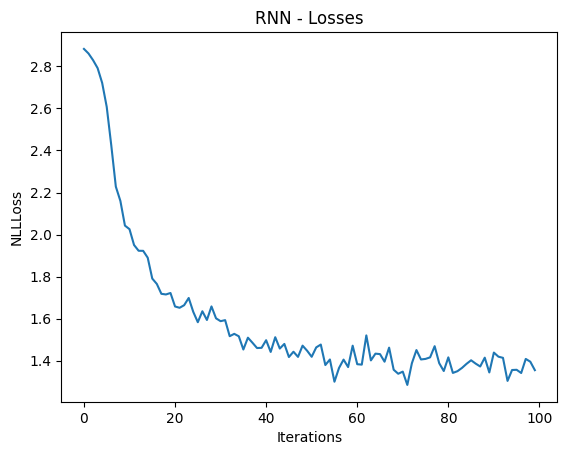

In [26]:
print_losses(rnn_losses, 'RNN - Losses')

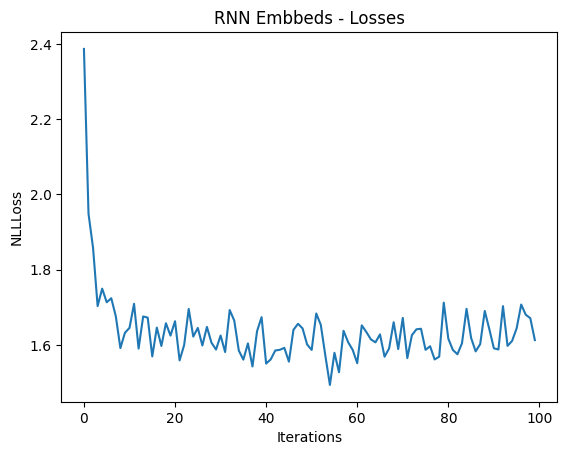

In [27]:
print_losses(rnn_embeds_losses, 'RNN Embbeds - Losses')

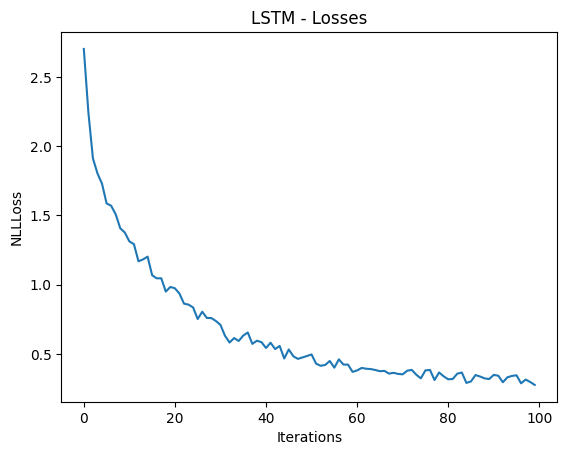

In [28]:
print_losses(lstm_losses, 'LSTM - Losses')

In [29]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()

    line_tensor = line_tensor.to(device)

    hidden = model.initHidden()

    with torch.inference_mode():
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

    return output

def create_confusion_matrix(model):
  # Keep track of correct guesses in a confusion matrix
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, _, _, line_tensor = randomTrainingExample(model.type_layer)
      output = evaluate(line_tensor, model)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig, ax = plt.subplots(figsize=(20, 20))
  cax = ax.matshow(confusion)

  # Display values inside the cells
  for i in range(len(all_categories)):
      for j in range(len(all_categories)):
          ax.text(j, i, str(round(confusion[i, j].item(), 3)), va='center', ha='center', color='white')

  fig.colorbar(cax, shrink=0.8)

  # Set up axes
  ax.set_xticklabels([''] + all_categories, rotation=45)
  ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.xaxis.set_label_coords(0.5, -0.1)
  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.set_ticks_position("none")

  plt.title(f'Confusion Matrix of {model.__class__.__name__}')
  plt.show()

<ipython-input-29-832f2ecd74a7>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-29-832f2ecd74a7>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


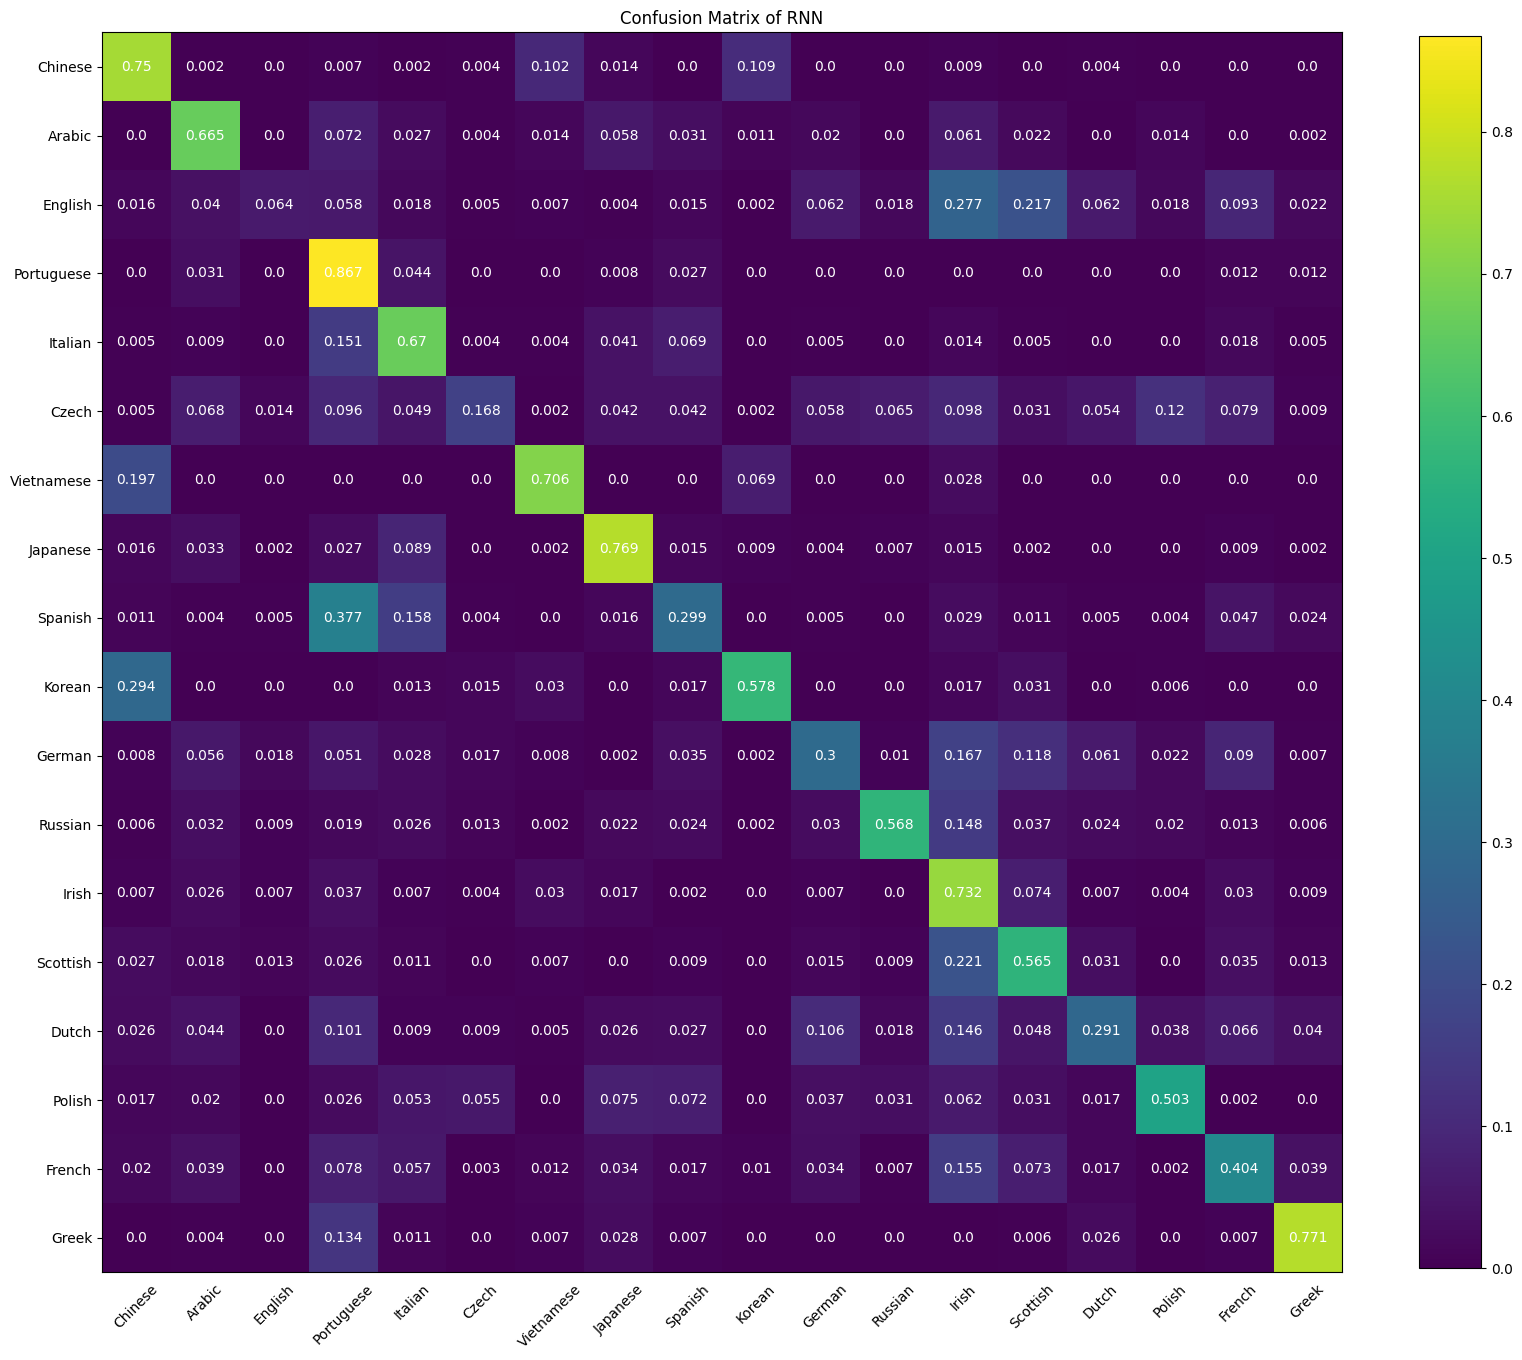

In [30]:
create_confusion_matrix(rnn)

<ipython-input-29-832f2ecd74a7>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-29-832f2ecd74a7>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


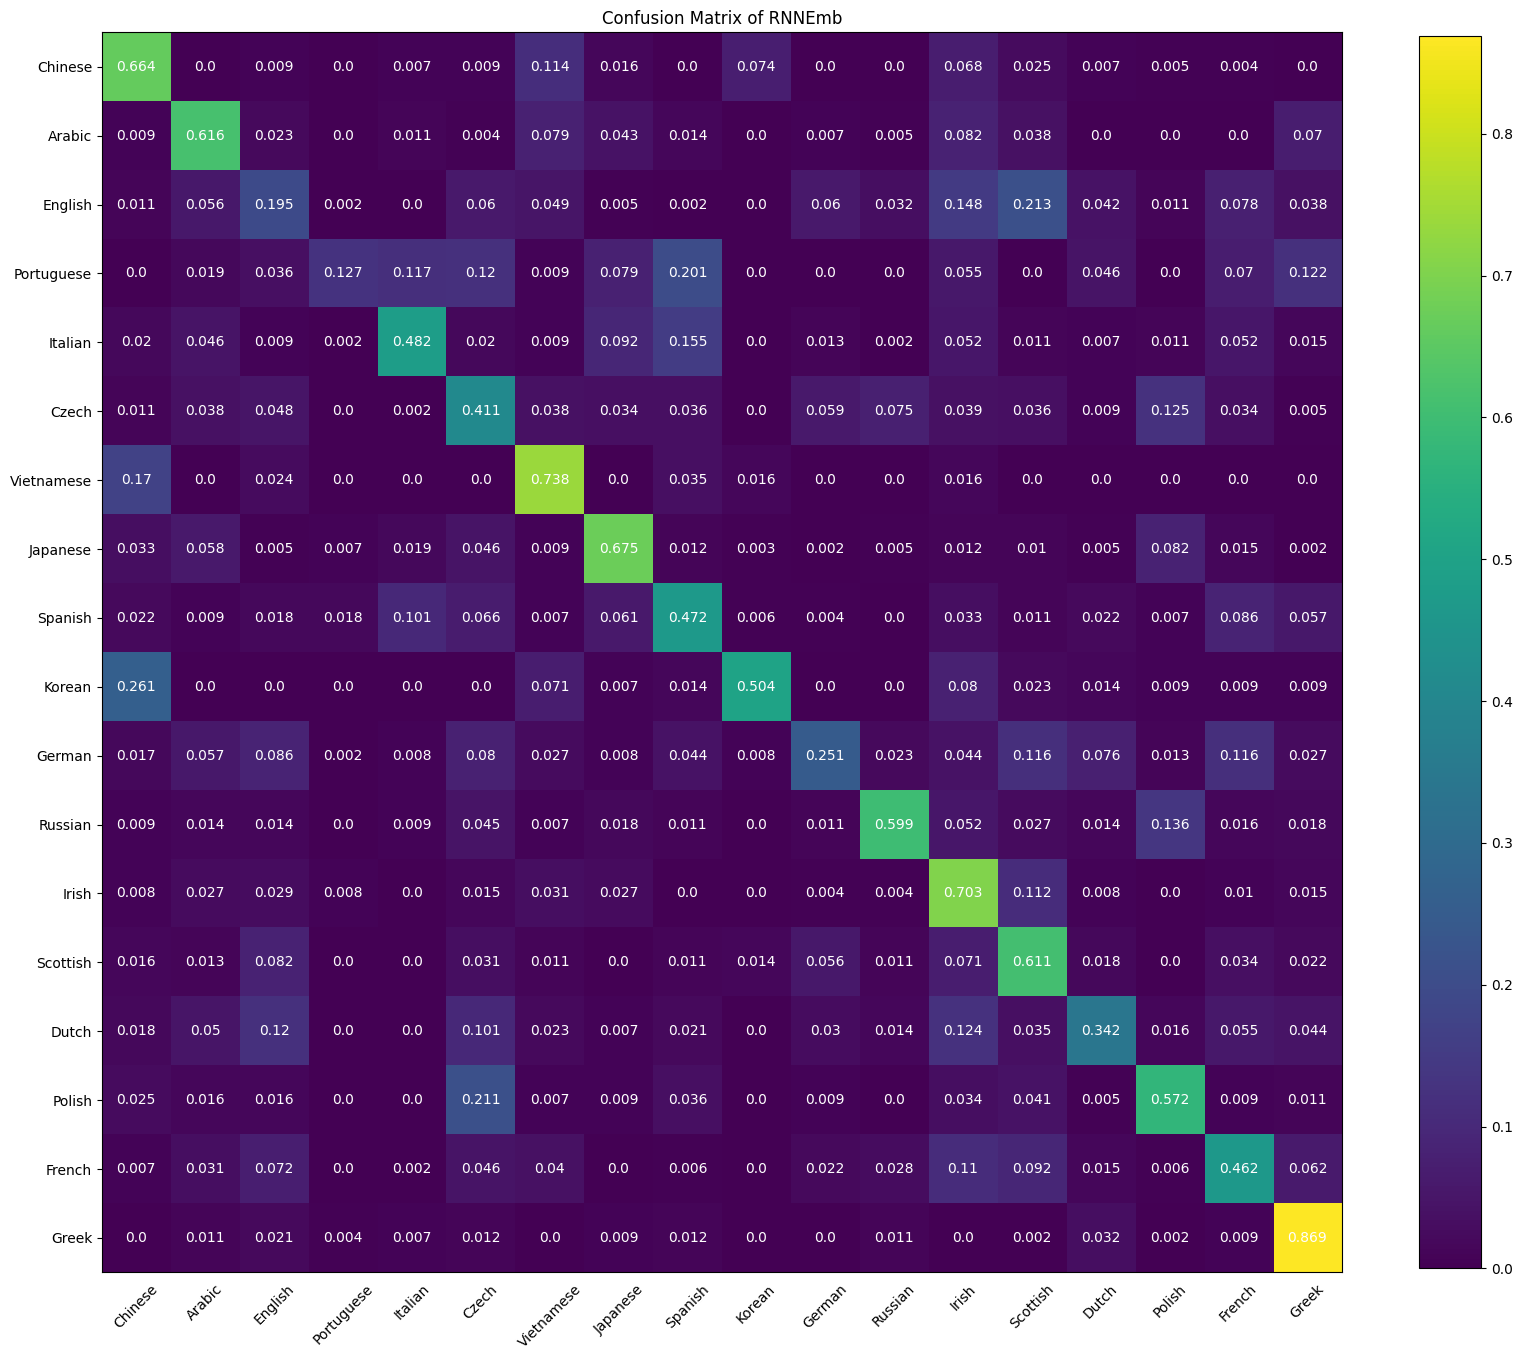

In [31]:
create_confusion_matrix(rnn_embeds)

<ipython-input-29-832f2ecd74a7>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-29-832f2ecd74a7>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


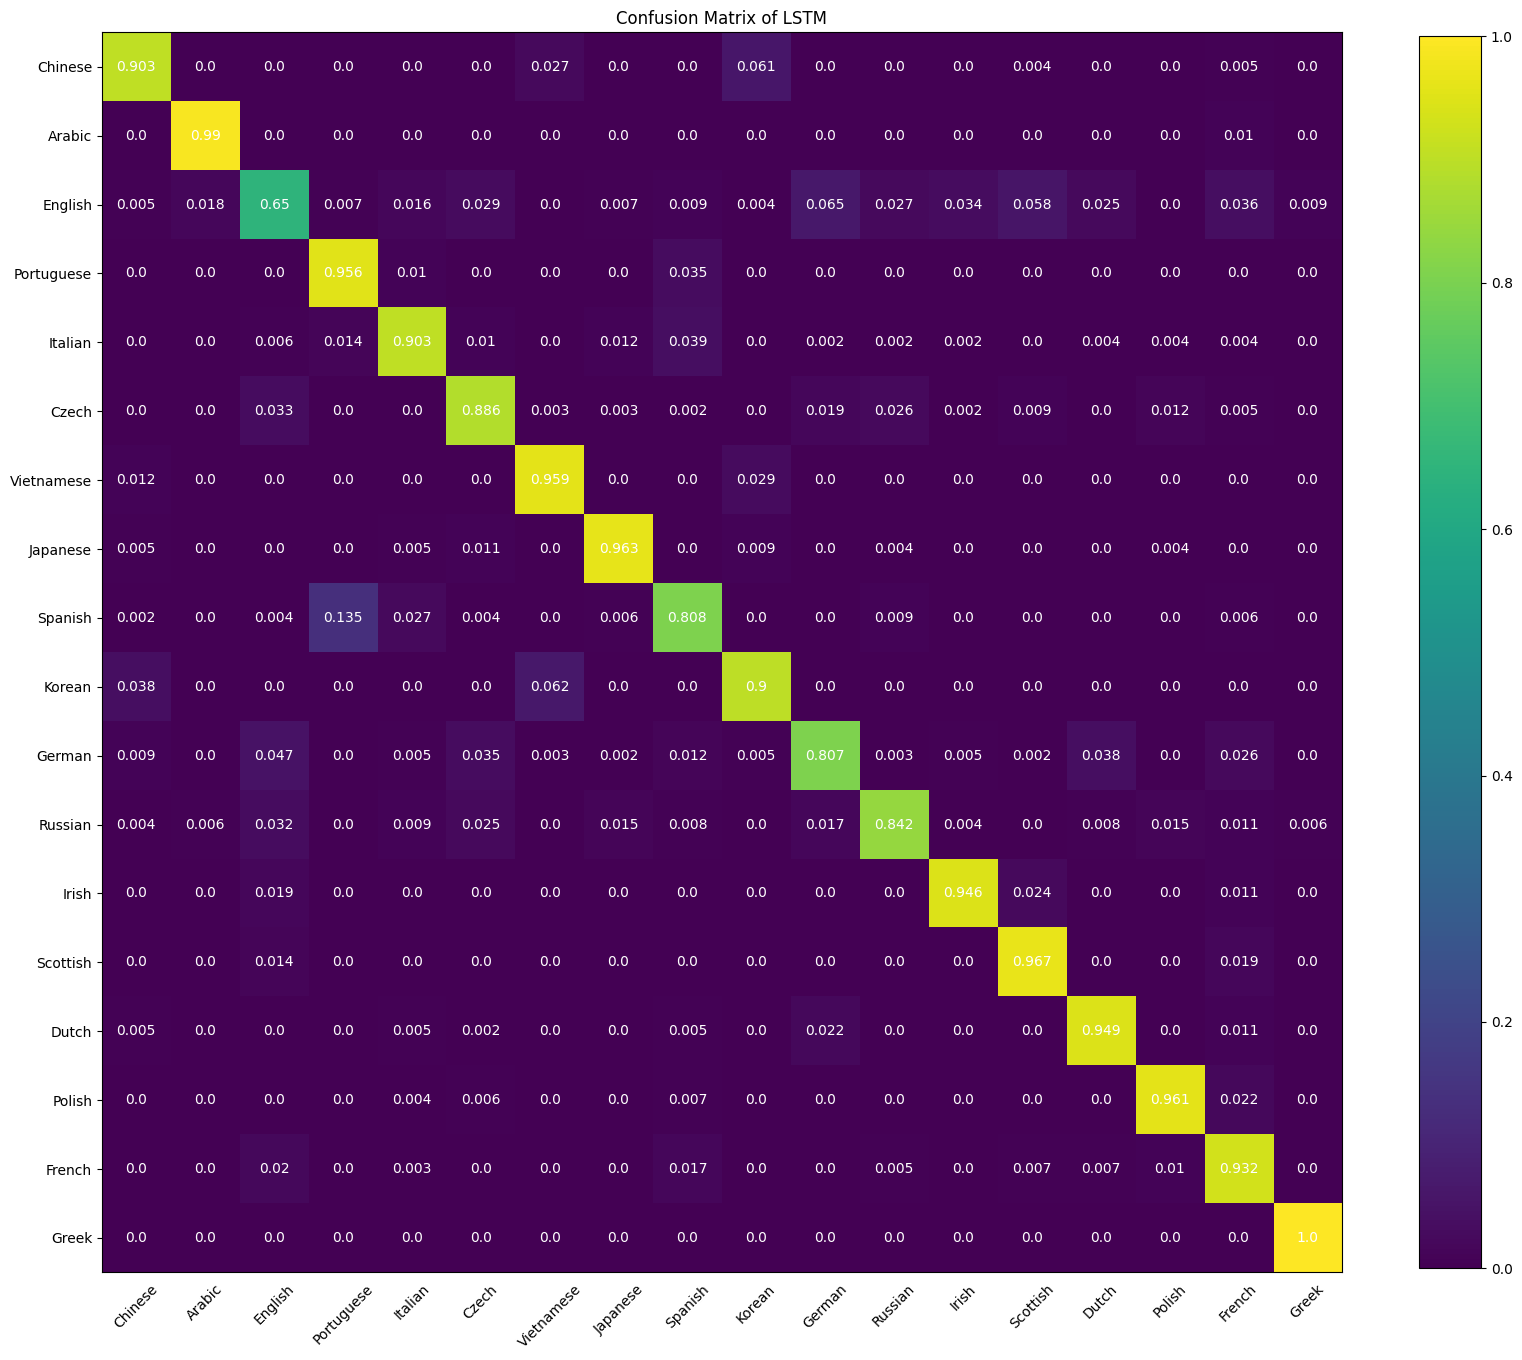

In [32]:
create_confusion_matrix(lstm)

# Question 6
Make a function to extract the embedding and visualise in the 2D space with the color w.r.t. the Language class. Feel free to modify the `get_embeddings()` function to return what you think could be useful for the plotting. Let's use also the cosine similarity between the embeddings to see if the embedding has a sense.

In [33]:
def getTrainingSample(word, type_layer):
    # create a long tensor with the index of the language
    if type_layer == 'linear': return wordToOneHotTensor(word)
    else: return wordToEmbedding(word)

In [34]:
def get_lists_and_dict(category_words):

  sournames, languages_sournames = [], []
  category_words_new = {}

  id = 0
  for lang, list_sournames in category_words.items():
    category_words_new[lang] = []
    for sourname in list_sournames:
      category_words_new[lang].append((id, sourname))
      sournames.append(sourname)
      languages_sournames.append(lang)
      id += 1

  return sournames, languages_sournames, category_words_new

# category_words_new -> dictionary similar to category_words with the additiona id in each sourname
# sournames -> list of sournames derived from the dictionary keys
# languages_sournames -> list of languages derived from the dictionary values

sournames, languages_sournames, category_words_new = get_lists_and_dict(category_words)

In [35]:
def evaluate(line_tensor, model):
    model.eval()
    line_tensor = line_tensor.to(device)

    hidden = model.initHidden()

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

    return output

In [36]:
def get_embeddings(model, category_words_new, lenght):

  embeddings = np.empty((0,128))

  model.eval()  # Set the model in evaluation mode

  # Extract hidden states from your dataset
  # Assuming you have a dataset of sequences, you can iterate over them and collect the hidden states

  correct = 0

  with torch.inference_mode():

      # Iterate over your dataset and extract hidden states
      for lang, list_sourname in category_words_new.items():

          for _, sourname in list_sourname:

              hidden = model.initHidden()

              tensor_sourname = getTrainingSample(sourname, model.type_layer).to(device)

              for i in range(tensor_sourname.size()[0]):
                  output, hidden = model(tensor_sourname[i], hidden)

              category_pred, _ = categoryFromOutput(output)
              if category_pred == lang: correct +=1

              if model.__class__.__name__ == 'LSTM':
                  embeddings = np.vstack((embeddings, hidden[0].cpu().numpy()))
              else:
                  embeddings = np.vstack((embeddings, hidden.cpu().numpy()))

  print(f'{model.__class__.__name__} - Accuracy on the whole set of sournames: {correct / lenght}')
  return embeddings

In [37]:
from sklearn.manifold import TSNE

def get_tsne_embeds(embeds, indices):
  embeds_tsne_indices = TSNE().fit_transform(embeds.squeeze()[indices,:])
  embeds_tsne_all = TSNE().fit_transform(embeds.squeeze()[:,:])
  return embeds_tsne_indices, embeds_tsne_all

In [38]:
import matplotlib.pyplot as plt

def print_embeddings(embeds_tsne_indices, indices, title):
    colors = ['darkblue', 'orange', 'green', 'mediumturquoise', 'darkmagenta', 'khaki', 'dimgray', 'royalblue', 'darkslategray', 'coral', 'mediumorchid', 'saddlebrown', 'lightpink', 'mediumseagreen', 'olivedrab', 'slategray', 'mediumvioletred', 'darkgoldenrod']

    fig, ax = plt.subplots(figsize=(12, 12))

    # Create an empty list to store unique legend entries
    legend_entries = []
    unique_languages = list(category_words.keys())

    for i, val in enumerate(indices):
        color = colors[unique_languages.index(languages_sournames[val])]

        # Check if the language is already in the legend_entries list
        if languages_sournames[val] not in legend_entries:
            # Add the language to legend_entries to avoid duplicates
            legend_entries.append(languages_sournames[val])
            plt.scatter(*embeds_tsne_indices[i, :], color=color, label=languages_sournames[val])
        else:
            # If the language is already in legend_entries, don't add a label
            plt.scatter(*embeds_tsne_indices[i, :], color=color)

    plt.title(title)

    # Display the legend with unique entries
    plt.legend()
    plt.show()

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

def get_embds_sim(embs):
  sim = cosine_similarity(embs)
  np.fill_diagonal(sim, -1.0)
  return sim

In [40]:
viz_words = 2000
indices = np.random.choice(len(sournames), viz_words)

RNN - Accuracy on the whole set of sournames: 0.4912822556540799


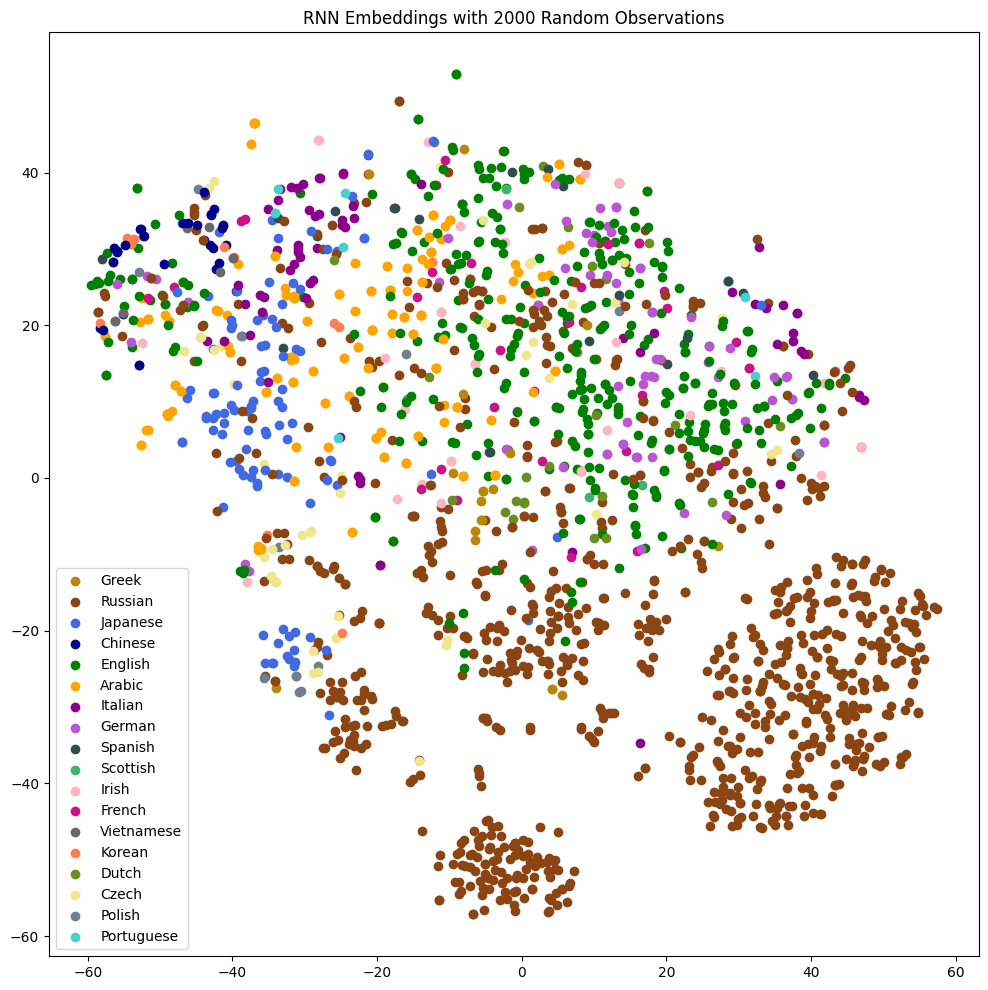

In [41]:
embeds_rnn = get_embeddings(rnn, category_words_new, len(sournames))
embeds_tsne_indices_rnn, embeds_tsne_all_rnn = get_tsne_embeds(embeds_rnn, indices)
print_embeddings(embeds_tsne_indices_rnn, indices, f'RNN Embeddings with {viz_words} Random Observations')
sim_rnn = get_embds_sim(embeds_rnn)

RNNEmb - Accuracy on the whole set of sournames: 0.5073727209325496


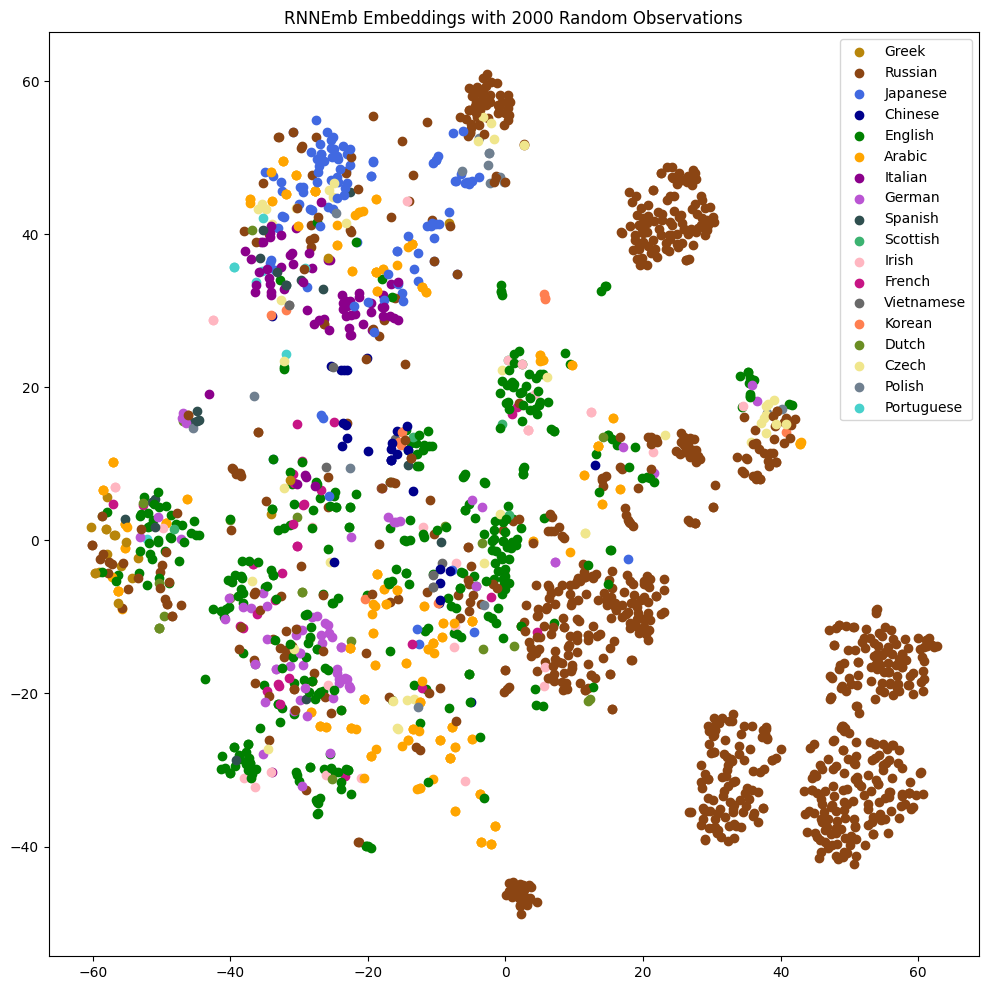

In [42]:
embeds_rnn_emb = get_embeddings(rnn_embeds, category_words_new, len(sournames))
embeds_tsne_indices_rnn_emb, embeds_tsne_all_rnn_emb = get_tsne_embeds(embeds_rnn_emb, indices)
print_embeddings(embeds_tsne_indices_rnn_emb, indices, f'RNNEmb Embeddings with {viz_words} Random Observations')
sim_rnn_emb = get_embds_sim(embeds_rnn_emb)

LSTM - Accuracy on the whole set of sournames: 0.845023413370529


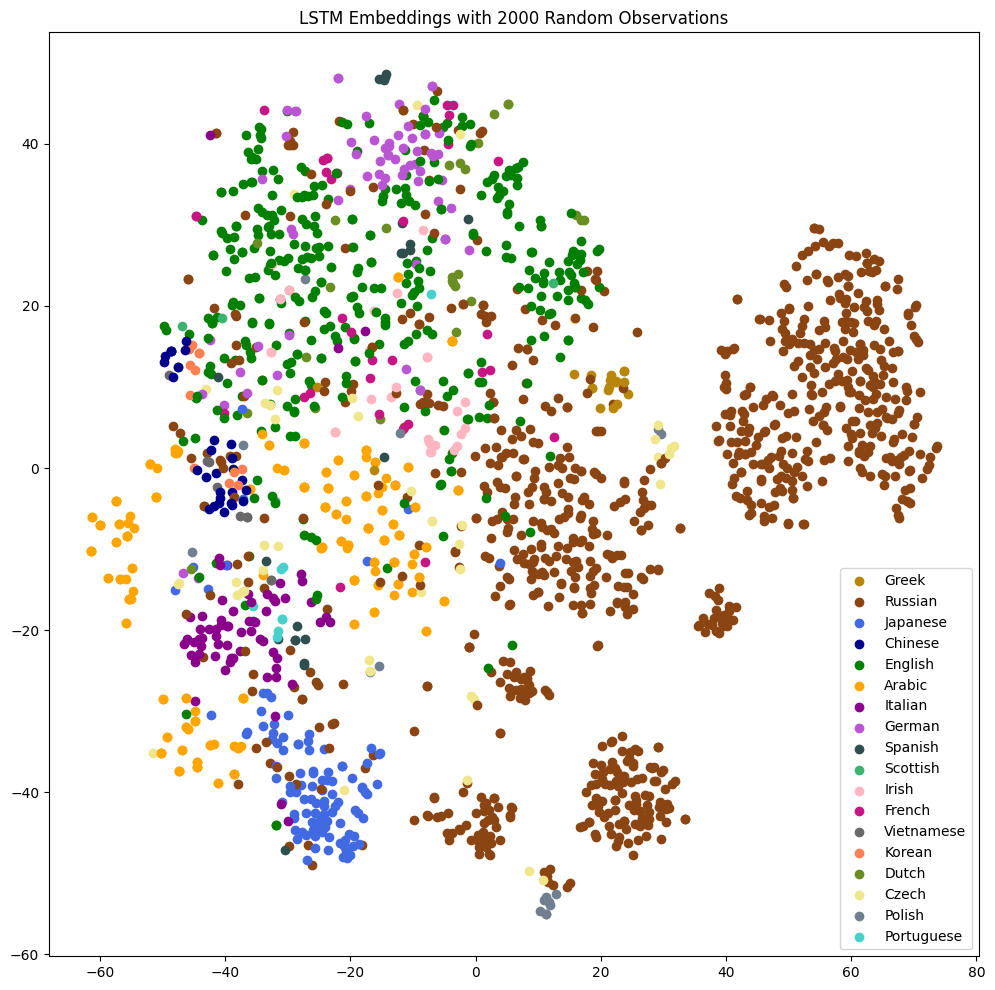

In [43]:
embeds_lstm = get_embeddings(lstm, category_words_new, len(sournames))
embeds_tsne_indices_lstm, embeds_tsne_all_lstm = get_tsne_embeds(embeds_lstm, indices)
print_embeddings(embeds_tsne_indices_lstm, indices, f'LSTM Embeddings with {viz_words} Random Observations')
sim_lstm = get_embds_sim(embeds_lstm)

In [82]:
def get_random_sournames_languages():
  list_idxs_lan_mat_sim = []
  for lang, sournames_list in category_words_new.items():

    id_rand_sourname, str_rand_sourname = random.sample(sournames_list, 1)[0]

    list_idxs_lan_mat_sim.append((id_rand_sourname, languages_sournames[id_rand_sourname]))

  return list_idxs_lan_mat_sim

list_idxs_lan_mat_sim = get_random_sournames_languages()

for id, lan in list_idxs_lan_mat_sim: print(f'{id} - {sournames[id]} - {lan}')

252 - Xin - Chinese
918 - Attia - Arabic
3992 - Jury - English
5952 - Cruz - Portuguese
6127 - Amerighi - Italian
6848 - Herodes - Czech
7307 - Van - Vietnamese
7966 - Otake - Japanese
8315 - Alamilla - Spanish
8668 - Shon - Korean
9345 - Vogel - German
15493 - Nezhlukto - Russian
19011 - Pharlain - Irish
19119 - Muir - Scottish
19178 - Ankeren - Dutch
19465 - Budny - Polish
19786 - Paget - French
19952 - Houlis - Greek


In [83]:
def get_names_similarity(list_idxs_lan_mat_sim, embs_sim, top_k):

  dict_to_return = {}

  for values in list_idxs_lan_mat_sim:

    idx_in_mat_sim, lang = values
    count_correct_top_k = 0

    most_sim_sournames_idx = np.flip(np.argsort(embs_sim[idx_in_mat_sim]))[:top_k]
    most_sim_sournames_str = [sournames[idx] for idx in most_sim_sournames_idx]

    most_sim_sournames_lan = []
    for idx in most_sim_sournames_idx:
      most_sim_sournames_lan.append(languages_sournames[idx])


    most_similar_sournames_sim = [embs_sim[idx_in_mat_sim, idx] for idx in most_sim_sournames_idx]

    dict_to_return[idx_in_mat_sim] = (lang, most_sim_sournames_idx)

    print(f'Most similar name for "{sournames[idx_in_mat_sim]} - ({lang})" are:\t{most_sim_sournames_str}')
    print(f'With corresponding languages:\t{most_sim_sournames_lan}')
    print(f'With corresponding indices:\t{most_sim_sournames_idx}')
    print(f'With corresponding Embedding Cosine Similarity of:\t{most_similar_sournames_sim}')
    print(f'Accuracy for the Top-{top_k}:\t{count_correct_top_k / top_k}')
    print(f'Mean Cosine Similarity for the Top-{top_k} is:\t{np.mean(np.array(most_similar_sournames_sim))}\n')

  return dict_to_return

In [84]:
# set the top-k names to see for a random name for each language
top_k = 50

In [85]:
dict_sim_rnn = get_names_similarity(list_idxs_lan_mat_sim, sim_rnn, top_k)

Most similar name for "Xin - (Chinese)" are:	['Qin', 'Min', 'Yin', 'Yin', 'Jin', 'Jin', 'Fin', 'Sin', 'Yun', 'Yun', 'Yan', 'Yan', 'Yan', 'Wan', 'Wan', 'Xun', 'Lin', 'Gan', 'Jan', 'Han', 'Han', 'Han', 'Han', 'Fan', 'Jun', 'Yim', 'Yim', 'Man', 'Mun', 'Won', 'Wen', 'Sun', 'Sun', 'Gim', 'Kan', 'Kan', 'Kan', 'San', 'Sip', 'Xie', 'Xie', 'Sen', 'Sen', 'an', 'Ban', 'Jon', 'Gil', 'Pan', 'Pan', 'Ahn']
With corresponding languages:	['Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Russian', 'Korean', 'Chinese', 'Korean', 'Russian', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Russian', 'Korean', 'Russian', 'Vietnamese', 'Chinese', 'Chinese', 'Russian', 'Korean', 'Chinese', 'Chinese', 'Russian', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Dutch', 'Japanese', 'Chinese', 'Korean', 'Czech', 'Chinese', 'Chinese', 'Japanese', 'Russian', 'Vietnamese', 'Chinese', 'Korean', 'Korean', 'French', 'Chinese', 'Korean']
With corresponding indices:	[ 

In [86]:
dict_sim_rnn_emb = get_names_similarity(list_idxs_lan_mat_sim, sim_rnn_emb, top_k)

Most similar name for "Xin - (Chinese)" are:	['Xun', 'Qin', 'Bachaldin', 'Fin', 'Zhimerin', 'Xie', 'Xie', 'Dobrusin', 'Dobrotin', 'Perrin', 'Batchaldin', 'Paimullin', 'Hudaiberdin', 'Nasibullin', 'Vasindin', 'Chepurin', 'Teterin', 'Jurin', 'Abdullin', 'Valdin', 'Séverin', 'Nasybullin', 'Averin', 'Zinatullin', 'Shamardin', 'Jorin', 'Rahmatullin', 'Gan', 'Jin', 'Jin', 'Dubrovin', 'Dobrynin', 'Bakholdin', 'Baholdin', 'Oboldin', 'Lin', 'Balabolkin', 'Avrorin', 'Sin', 'Jenin', 'Vydrin', 'Haibullin', 'Chamberlain', 'Antoschin', 'Abaidullin', 'Baburkin', 'Rovnin', 'Dobychin', 'Elvin', 'Hamadullin']
With corresponding languages:	['Chinese', 'Chinese', 'Russian', 'Russian', 'Russian', 'Chinese', 'Chinese', 'Russian', 'Russian', 'English', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'French', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Chinese', 'Chinese', 'Chinese', 'Russian', 'Russian', 'Russian', 'Russian

In [87]:
dict_sim_lstm = get_names_similarity(list_idxs_lan_mat_sim, sim_lstm, top_k)

Most similar name for "Xin - (Chinese)" are:	['Xie', 'Xie', 'Xian', 'Xun', 'Zhen', 'Yin', 'Yin', 'Yun', 'Yun', 'Xuan', 'Jin', 'Jin', 'Min', 'Jun', 'Mun', 'Xing', 'Xing', 'Chin', 'Chin', 'Xue', 'Thien', 'Frumin', 'Qin', 'Huie', 'Yuan', 'Yuan', 'Zhun', 'Huzin', 'Lin', 'Yan', 'Yan', 'Yan', 'Shen', 'Shen', 'Juan', 'Xiao', 'Yue', 'Shin', 'Fin', 'Lian', 'Jian', 'Guzun', 'Mih', 'Tzei', 'Yee', 'Vainshtein', 'Won', 'Mein', 'Munehin', 'Yim']
With corresponding languages:	['Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Russian', 'Russian', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'Chinese', 'Chinese', 'Russian', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Russian', 'Russian', 'Chinese', 'Chinese', 'Chinese', 'Russian', 'Russian', 'Chinese', 'Chinese', 'Chinese', 'Chinese', 'Korean', 'Russian', 'Chinese', 'Chinese', 'Russian', 'Russian', 'Russian', 'Chinese', 'Russian', 'Chinese', 'German', 'Russian'

In [88]:
import seaborn as sns

def plot_point_features(xy_tsne, dictionary, sournames, title):
  x = xy_tsne[:,0]
  y = xy_tsne[:,1]


  plt.figure(figsize=(20, 20))
  plot = sns.scatterplot(x=x, y=y)

  list_colors = ['darkblue', 'orange', 'green', 'mediumturquoise', 'darkmagenta', 'khaki', 'dimgray', 'royalblue', 'darkslategray', 'coral', 'mediumorchid', 'saddlebrown', 'lightpink', 'mediumseagreen', 'olivedrab', 'slategray', 'mediumvioletred', 'darkgoldenrod']
  j = 0

  for target_index, (lang, list_idx_sournames) in dictionary.items():

      plot.text(x[target_index], y[target_index], sournames[target_index], horizontalalignment='center', size='small', color='black', weight='semibold')
      plt.scatter(x[target_index], y[target_index], marker='o', color=list_colors[j])

      top_similar_x = [x[i] for i in list_idx_sournames]
      top_similar_y = [y[i] for i in list_idx_sournames]

      plt.scatter(top_similar_x, top_similar_y, marker='o', color=list_colors[j], label=f'Similar to {sournames[target_index]} ({lang})')

      j += 1

  plt.title(title)
  plt.legend()
  plt.show()

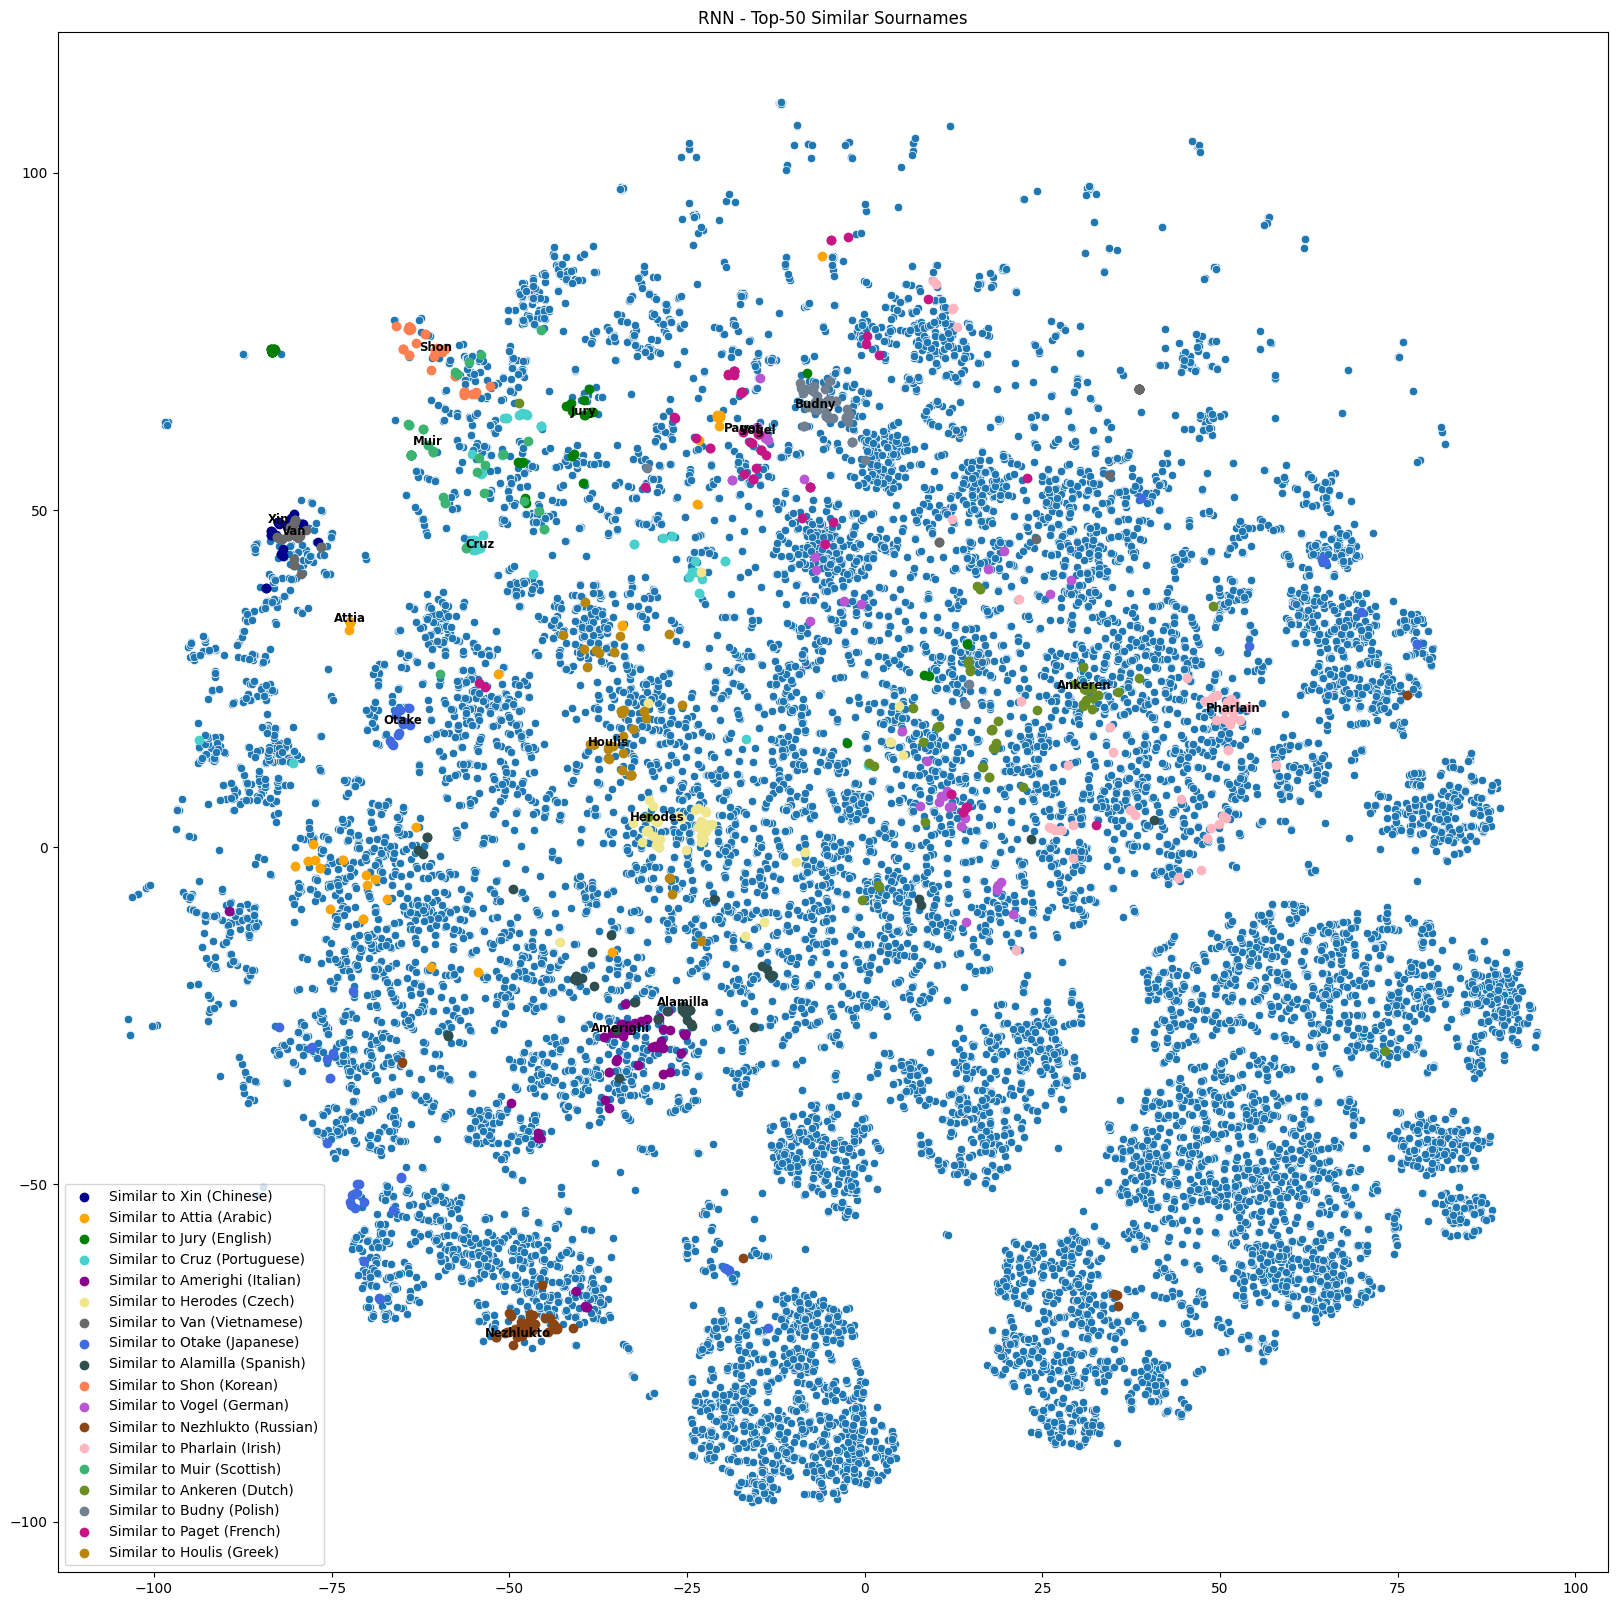

In [89]:
plot_point_features(embeds_tsne_all_rnn, dict_sim_rnn, sournames, f'RNN - Top-{top_k} Similar Sournames')

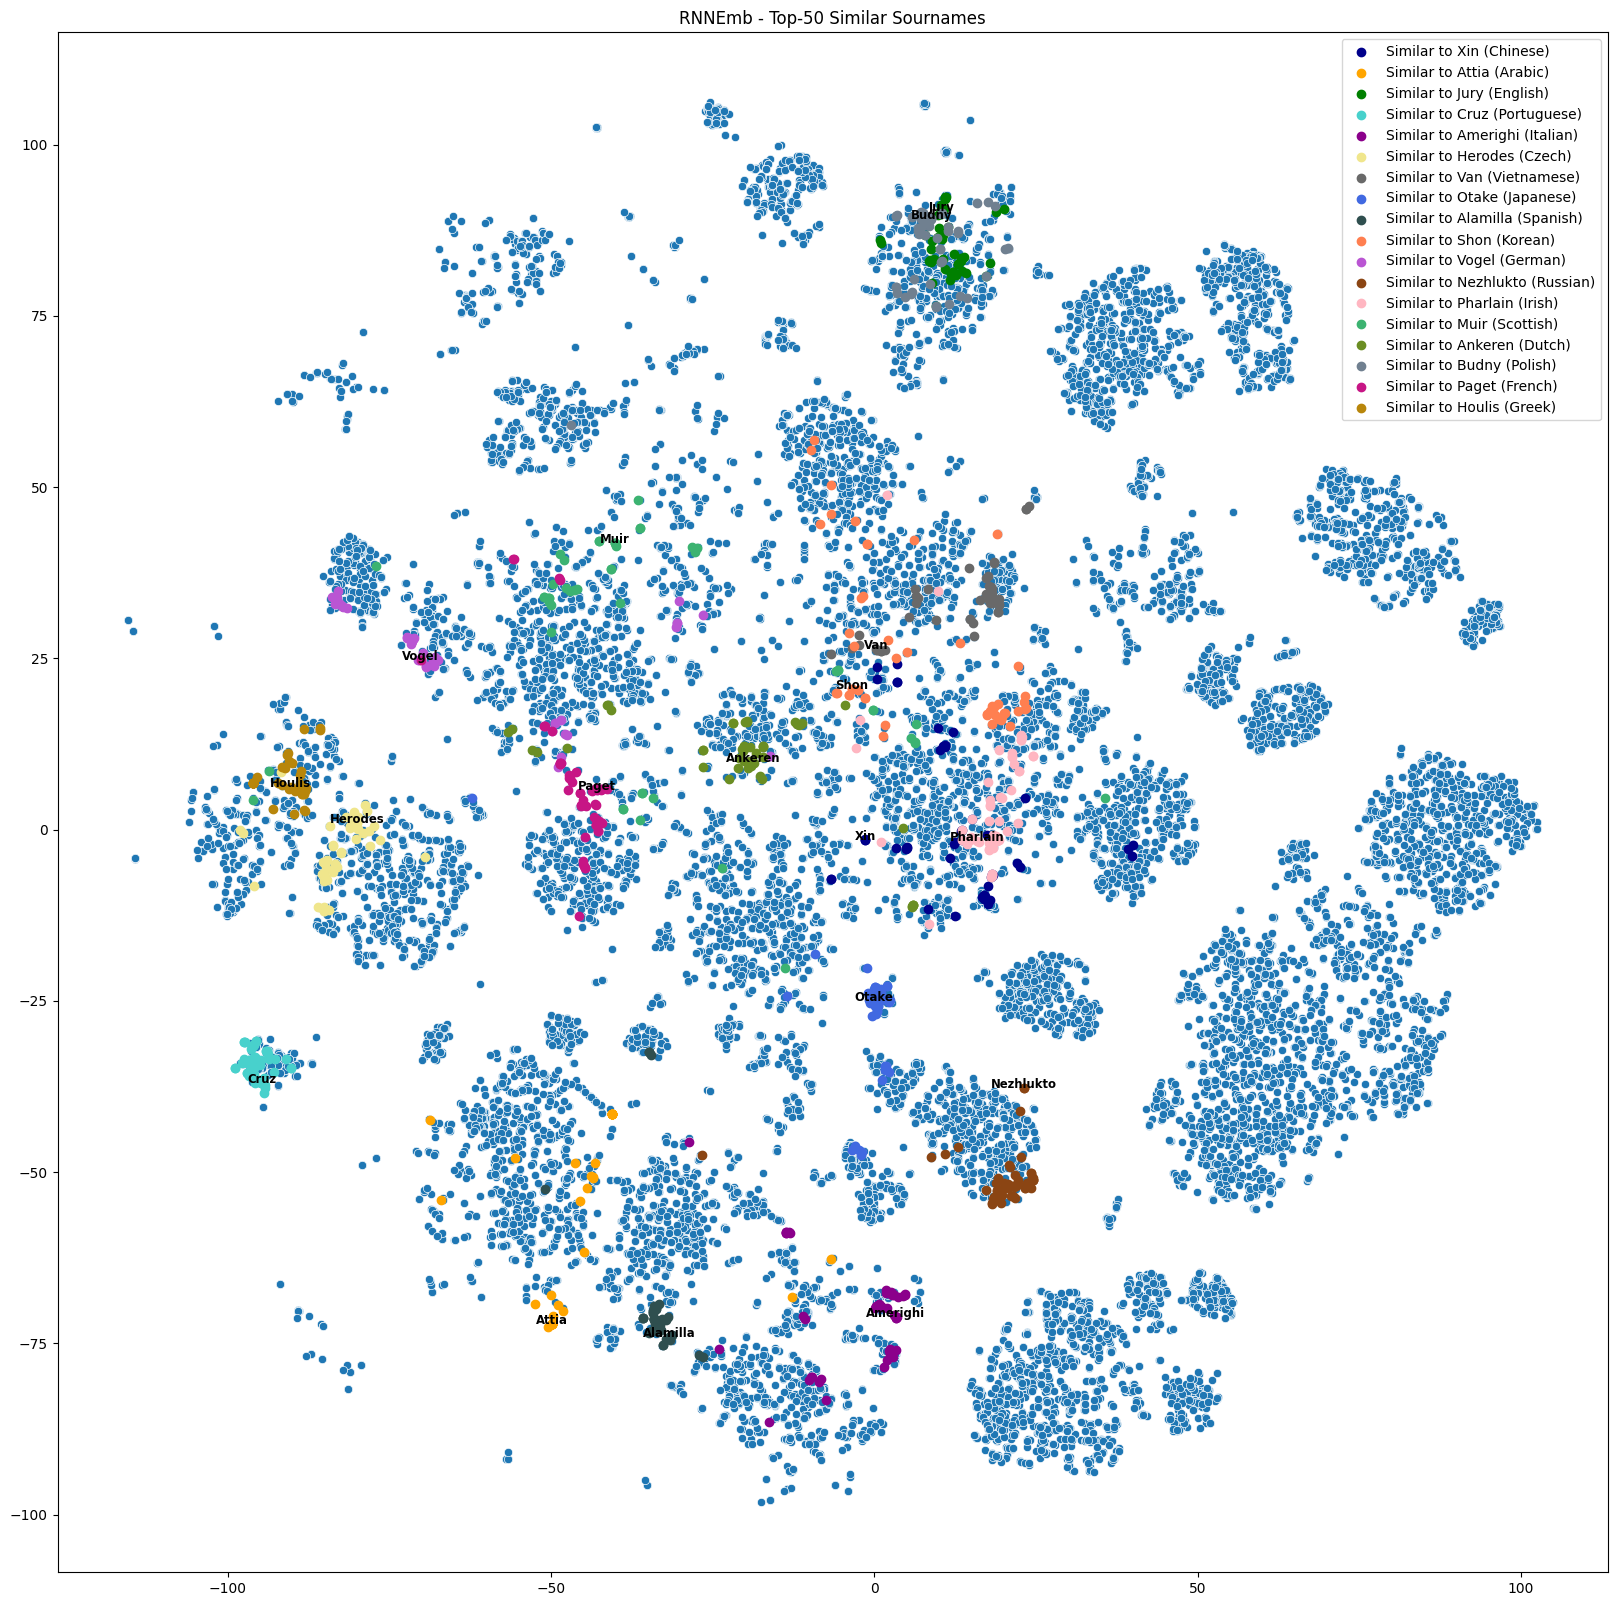

In [90]:
plot_point_features(embeds_tsne_all_rnn_emb, dict_sim_rnn_emb, sournames, f'RNNEmb - Top-{top_k} Similar Sournames')

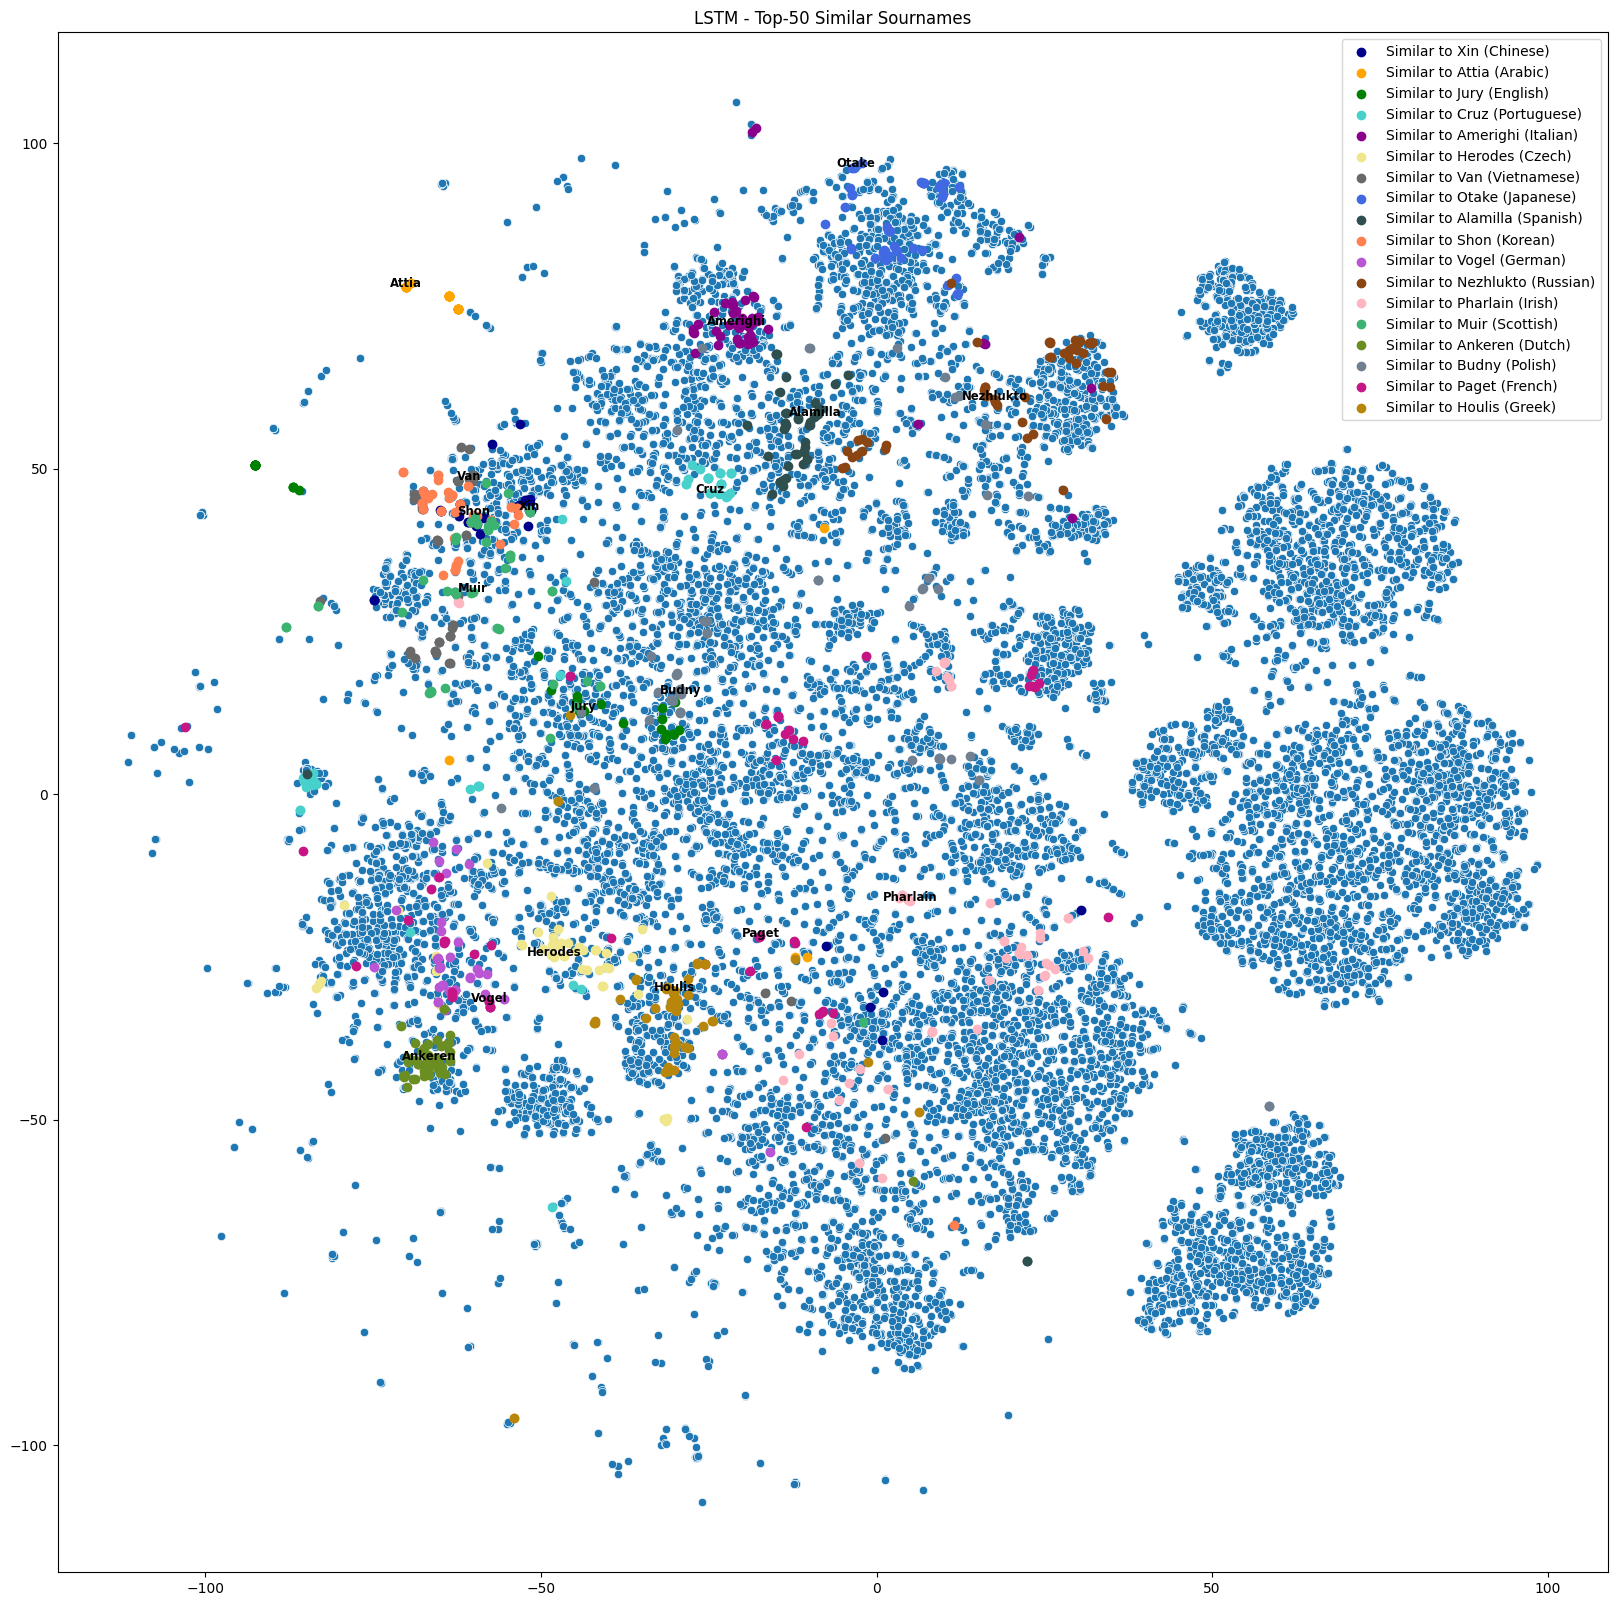

In [91]:
plot_point_features(embeds_tsne_all_lstm, dict_sim_lstm, sournames, f'LSTM - Top-{top_k} Similar Sournames')

# Final Thoughts

In this assignment we have done an implementation of a classical RNN, an RNN using an embedding layer and an LSTM.

In the initial steps we have plotted the loss viewing a continuing decreasing in value, which is always a good sing, moreover we have plotted the confusion matrix using a random set of surnames analysing if the model was able to predict correctly the origin of each surname and since that analysis we saw that LSTM actually outperform the other two models RNN and RNNEmb.

Not satisfied we have extracted the actual embeddings using the evaluation mode of each model for the all set of surnames printing out the actual accuracy and we saw that the confusion matrix of a subset of observation was a good approximation indeed the LSTM has an accuracy more or less of the 84% much higher respect the other two.

Continuing we have plotted the dimensionally reduced embedding using the t-SNE dimensionality reduction method of 2000 random samples in order to have some kind of general visualization of the category separation of each model. And we saw that RNNEmb seems to separate the category much better with respect to the other two. This fact is mainly due to the Embedding layer that we have added.

Now again not satisfied we decided to make an additional analysis using the cosine similarity from the sklearn python package. More precisely we decide to get a random sourname from each language surname set and take the topk most similar surname using the cosine similarity. This step was done in order to obtain a clear idea if the embedding of each model represent correctly the problem space or not.

Below we report the TopK Accuracy and the Average TopK Cosine Similarity of the three models for each sampled sourname from each language.
\begin{array}{|l|l|l|l|l|l|l|}
    \hline
        Language Sourname & RNN - TopK Accuracy & RNN - Average TopK Cosine Similarity & RNNEmb - TopK Accuracy & RNNEmb - Average TopK Cosine Similarity & LSTM - TopK Accuracy & LSTM - Average TopK Cosine Similarity \\ \hline
        Chinese & 0.54 & 0.78 & 0.16 & 0.74 & 0.66 & 0.59 \\ \hline
        Arabic & 0.48 & 0.81 & 0.62 & 0.76 & 0.88 & 0.69 \\ \hline
        English & 0.36 & 0.67 & 0.94 & 0.72 & 0.4 & 0.64 \\ \hline
        Portuguese & 0.04 & 0.67 & 0.02 & 0.68 & 0.3 & 0.48 \\ \hline
        Italian & 0.82 & 0.80 & 0.26 & 0.68 & 0.72 & 0.59 \\ \hline
        Czech & 0.0 & 0.84 & 0.06 & 0.72 & 0.14 & 0.59 \\ \hline
        Vietnamese & 0.1 & 0.75 & 0.08 & 0.74 & 0.2 & 0.53 \\ \hline
        Japanese & 0.54 & 0.72 & 0.48 & 0.71 & 0.98 & 0.73 \\ \hline
        Spanish & 0.18 & 0.84 & 0.2 & 0.76 & 0.5 & 0.61 \\ \hline
        Korean & 0.16 & 0.72 & 0.06 & 0.73 & 0.28 & 0.58 \\ \hline
        German & 0.28 & 0.77 & 0.1 & 0.72 & 0.38 & 0.58 \\ \hline
        Russian & 0.98 & 0.77 & 1.0 & 0.80 & 0.9 & 0.65 \\ \hline
        Irish & 0.1 & 0.83 & 0.04 & 0.78 & 0.28 & 0.62 \\ \hline
        Scottish & 0.02 & 0.64 & 0.0 & 0.57 & 0.04 & 0.44 \\ \hline
        Dutch & 0.22 & 0.77 & 0.46 & 0.66 & 0.56 & 0.70 \\ \hline
        Polish & 0.0 & 0.76 & 0.0 & 0.74 & 0.06 & 0.52 \\ \hline
        French & 0.08 & 0.71 & 0.3 & 0.72 & 0.2 & 0.53 \\ \hline
        Greek & 0.22 & 0.80 & 0.26 & 0.75 & 0.46 & 0.54 \\ \hline
    \end{array}

With this table we want to emphasize the fact that RNN and RNNEmb generate similar embedding but they do not represent the data in a good manner since we have a very poor accuracy in the topk surnames, whereas the cosine similarity is high. But the cosine similarity actually does not take into account the label of each embedding, indication again a bad embedding even if the dimensionally reduced plot seems pretty good. So in other words RNN and RNNEmb cannot differentiate surnames from different languages.

On the other hand LSTM, although it has more distant embeddings for surnames of the same language, manages to differentiate surnames from different languages. And therefore the embedding is better: it has learned the distribution of the data better. This fact can be seen by looking at the last two columns in which we can see that the average cosine similarity for the topk surnames is lower with respect to the other two models, but the accuracy of the topk surname is higher in most cases.

## Note
This conclusions are drawn taking into account the saved example running again the whole notebook could give different result.

Indeed all the values of the previous table are measure taking account a random surname from each language so it depend of course on the nature of the surname if it has a unique features to be able to differentiate from all the other surnames or it is similar to other surnames of different languages.